In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Load data
df = pd.read_csv("../data/merged_with_property.csv", low_memory=False)

# Exchange rates
DKK_TO_EUR = 0.134
NOK_TO_EUR = 0.085

# Convert prices to EUR
df['price_eur'] = df.apply(
    lambda row: row['price_local'] * DKK_TO_EUR if row['city'] == 'Copenhagen'
    else row['price_local'] * NOK_TO_EUR, axis=1
)

# NEW: keep only positive prices and take log
df = df[df['price_eur'].notna() & (df['price_eur'] > 0)].copy()
df['log_price_eur'] = np.log(df['price_eur'])

# IMPORTANT: Bayesian analysis now uses log(price_eur)
dk_data = df[df['city'] == 'Copenhagen']['log_price_eur'].dropna()
no_data = df[df['city'] == 'Oslo']['log_price_eur'].dropna()

print(f"Copenhagen: n={len(dk_data)}, mean(log)={dk_data.mean():.4f}, std(log)={dk_data.std():.4f}")
print(f"Oslo:       n={len(no_data)}, mean(log)={no_data.mean():.4f}, std(log)={no_data.std():.4f}")

Copenhagen: n=13831, mean(log)=5.0935, std(log)=0.5113
Oslo:       n=8701, mean(log)=4.7176, std(log)=0.5747


In [2]:
# Bayesian inference function (UNCHANGED)
def calculate_posterior(price_data, prior_mu=150, prior_tau=100):
    n = len(price_data)
    data_mu = price_data.mean()
    data_sigma = price_data.std()
    
    precision_prior = 1 / (prior_tau**2)
    precision_data = n / (data_sigma**2)
    
    post_mu = (prior_mu * precision_prior + data_mu * precision_data) / (precision_prior + precision_data)
    post_tau = np.sqrt(1 / (precision_prior + precision_data))
    
    return post_mu, post_tau

# NEW: Prior is on log scale now
prior_mu = np.log(150)   # centered around 150 EUR on original scale
prior_tau = 1.0          # weak prior on log scale

# Calculate posteriors ON LOG SCALE
mu_cph, tau_cph = calculate_posterior(dk_data, prior_mu=prior_mu, prior_tau=prior_tau)
mu_oslo, tau_oslo = calculate_posterior(no_data, prior_mu=prior_mu, prior_tau=prior_tau)

# Credible intervals for log means
ci_cph_log = stats.norm.interval(0.95, loc=mu_cph, scale=tau_cph)
ci_oslo_log = stats.norm.interval(0.95, loc=mu_oslo, scale=tau_oslo)

# Back-transform: exp(mu) is the geometric mean on EUR scale
mu_cph_eur = np.exp(mu_cph)
mu_oslo_eur = np.exp(mu_oslo)
ci_cph_eur = (np.exp(ci_cph_log[0]), np.exp(ci_cph_log[1]))
ci_oslo_eur = (np.exp(ci_oslo_log[0]), np.exp(ci_oslo_log[1]))

# Mean difference on LOG SCALE
mu_delta = mu_cph - mu_oslo
tau_delta = np.sqrt(tau_cph**2 + tau_oslo**2)
ci_delta_log = stats.norm.interval(0.95, loc=mu_delta, scale=tau_delta)

# NEW interpretation: ratio of geometric means (CPH/OSL)
ratio_median = np.exp(mu_delta)  # median of ratio posterior
ratio_ci = (np.exp(ci_delta_log[0]), np.exp(ci_delta_log[1]))
pct_median = (ratio_median - 1) * 100
pct_ci = ((ratio_ci[0] - 1) * 100, (ratio_ci[1] - 1) * 100)

prob_cph_higher = 1 - stats.norm.cdf(0, loc=mu_delta, scale=tau_delta)

# Print results
print("="*60)
print("BAYESIAN POSTERIOR ESTIMATES (log-price model)")
print("="*60)
print("Copenhagen (geometric mean EUR):")
print(f"Posterior exp(mu): {mu_cph_eur:.2f} EUR")
print(f"95% CrI: ({ci_cph_eur[0]:.2f}, {ci_cph_eur[1]:.2f}) EUR")
print("")
print("Oslo (geometric mean EUR):")
print(f"Posterior exp(mu): {mu_oslo_eur:.2f} EUR")
print(f"95% CrI: ({ci_oslo_eur[0]:.2f}, {ci_oslo_eur[1]:.2f}) EUR")
print("")
print("Relative difference (CPH/OSL):")
print(f"Median ratio: {ratio_median:.3f}  -> {pct_median:.1f}% higher")
print(f"95% CrI ratio: ({ratio_ci[0]:.3f}, {ratio_ci[1]:.3f}) -> ({pct_ci[0]:.1f}%, {pct_ci[1]:.1f}%)")
print(f"P(Δ_log > 0) = P(CPH > OSL): {prob_cph_higher:.6f}")
print("="*60)

BAYESIAN POSTERIOR ESTIMATES (log-price model)
Copenhagen (geometric mean EUR):
Posterior exp(mu): 162.95 EUR
95% CrI: (161.57, 164.35) EUR

Oslo (geometric mean EUR):
Posterior exp(mu): 111.90 EUR
95% CrI: (110.56, 113.26) EUR

Relative difference (CPH/OSL):
Median ratio: 1.456  -> 45.6% higher
95% CrI ratio: (1.435, 1.478) -> (43.5%, 47.8%)
P(Δ_log > 0) = P(CPH > OSL): 1.000000


In [3]:
# Prior sensitivity analysis (log scale)
print("="*60)
print("PRIOR SENSITIVITY ANALYSIS (log-scale prior sd)")
print("="*60)
print(f"{'tau0':<12} {'ratio_med':<12} {'CI_lower':<12} {'CI_upper':<12} {'P(diff>0)':<12}")
print("-"*60)

tau0_list = [0.5, 1.0, 1.5, 2.0]  # log-scale prior std dev

for tau0 in tau0_list:
    mu_cph_s, tau_cph_s = calculate_posterior(dk_data, prior_mu=np.log(150), prior_tau=tau0)
    mu_oslo_s, tau_oslo_s = calculate_posterior(no_data, prior_mu=np.log(150), prior_tau=tau0)

    mu_delta_s = mu_cph_s - mu_oslo_s
    tau_delta_s = np.sqrt(tau_cph_s**2 + tau_oslo_s**2)

    ci_delta_s = stats.norm.interval(0.95, loc=mu_delta_s, scale=tau_delta_s)
    prob_gt0 = 1 - stats.norm.cdf(0, loc=mu_delta_s, scale=tau_delta_s)

    ratio_med = np.exp(mu_delta_s)
    ratio_ci = (np.exp(ci_delta_s[0]), np.exp(ci_delta_s[1]))

    print(f"{tau0:<12.2f} {ratio_med:<12.3f} {ratio_ci[0]:<12.3f} {ratio_ci[1]:<12.3f} {prob_gt0:<12.6f}")

PRIOR SENSITIVITY ANALYSIS (log-scale prior sd)
tau0         ratio_med    CI_lower     CI_upper     P(diff>0)   
------------------------------------------------------------
0.50         1.456        1.435        1.478        1.000000    
1.00         1.456        1.435        1.478        1.000000    
1.50         1.456        1.435        1.478        1.000000    
2.00         1.456        1.435        1.478        1.000000    


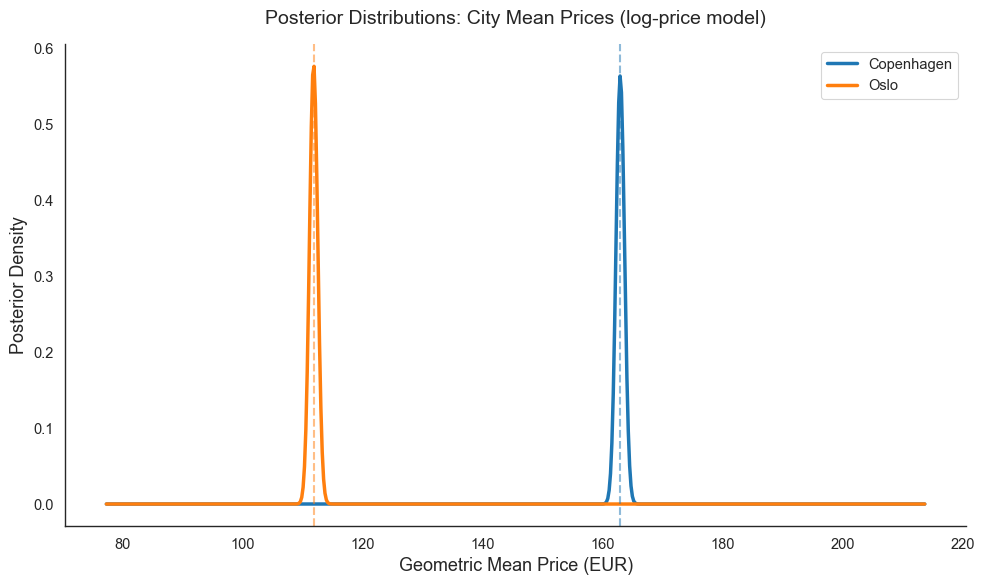

In [4]:
# Plot 1: Posterior distributions for each city (EUR scale via lognormal)

plt.figure(figsize=(10, 6))

# x range in EUR
x_range = np.linspace(
    min(ci_oslo_eur[0], ci_cph_eur[0]) * 0.7,
    max(ci_oslo_eur[1], ci_cph_eur[1]) * 1.3,
    600
)

# If mu ~ Normal(mu, tau), then exp(mu) ~ LogNormal(s=tau, scale=exp(mu))
pdf_cph = stats.lognorm.pdf(x_range, s=tau_cph, scale=np.exp(mu_cph))
pdf_osl = stats.lognorm.pdf(x_range, s=tau_oslo, scale=np.exp(mu_oslo))

plt.plot(x_range, pdf_cph, label='Copenhagen', linewidth=2.5, color='#1f77b4')
plt.plot(x_range, pdf_osl, label='Oslo', linewidth=2.5, color='#ff7f0e')

plt.axvline(np.exp(mu_cph), color='#1f77b4', linestyle='--', alpha=0.5, linewidth=1.5)
plt.axvline(np.exp(mu_oslo), color='#ff7f0e', linestyle='--', alpha=0.5, linewidth=1.5)

plt.xlabel('Geometric Mean Price (EUR)', fontsize=13)
plt.ylabel('Posterior Density', fontsize=13)
plt.title('Posterior Distributions: City Mean Prices (log-price model)', fontsize=14, pad=15)
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()
plt.savefig('posterior_city_means.png', dpi=300, bbox_inches='tight')
plt.show()

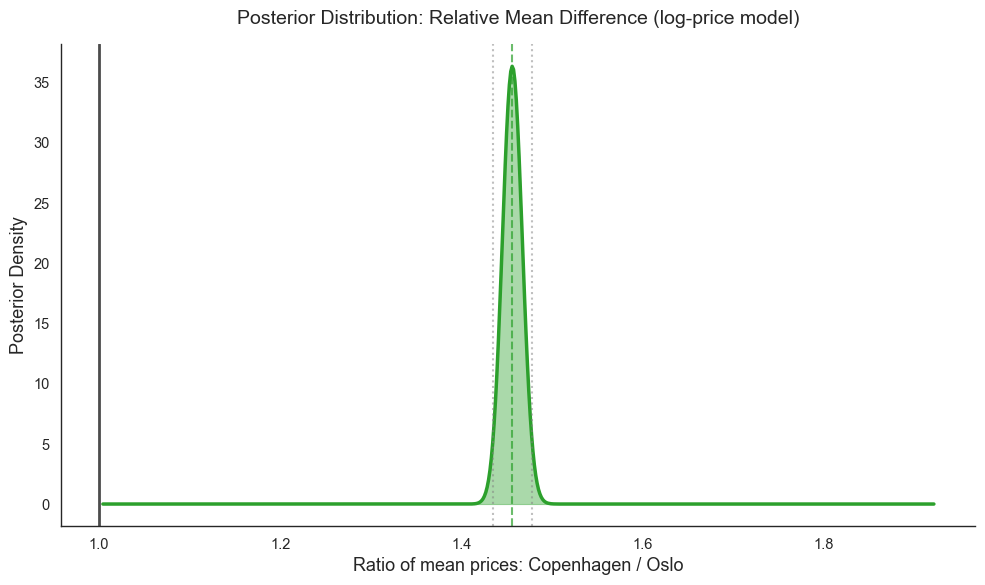

In [5]:
# Plot 2: Posterior distribution for the relative difference (ratio)

plt.figure(figsize=(10, 6))

ratio_range = np.linspace(ratio_ci[0] * 0.7, ratio_ci[1] * 1.3, 600)

# ratio = exp(delta_log) where delta_log ~ Normal(mu_delta, tau_delta)
pdf_ratio = stats.lognorm.pdf(ratio_range, s=tau_delta, scale=np.exp(mu_delta))

plt.fill_between(ratio_range, pdf_ratio, alpha=0.4, color='#2ca02c')
plt.plot(ratio_range, pdf_ratio, linewidth=2.5, color='#2ca02c')

plt.axvline(1, color='black', linestyle='-', linewidth=2, alpha=0.7)
plt.axvline(ratio_median, color='#2ca02c', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axvline(ratio_ci[0], color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
plt.axvline(ratio_ci[1], color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

plt.xlabel('Ratio of mean prices: Copenhagen / Oslo', fontsize=13)
plt.ylabel('Posterior Density', fontsize=13)
plt.title('Posterior Distribution: Relative Mean Difference (log-price model)', fontsize=14, pad=15)
sns.despine()
plt.tight_layout()
plt.savefig('posterior_difference.png', dpi=300, bbox_inches='tight')
plt.show()

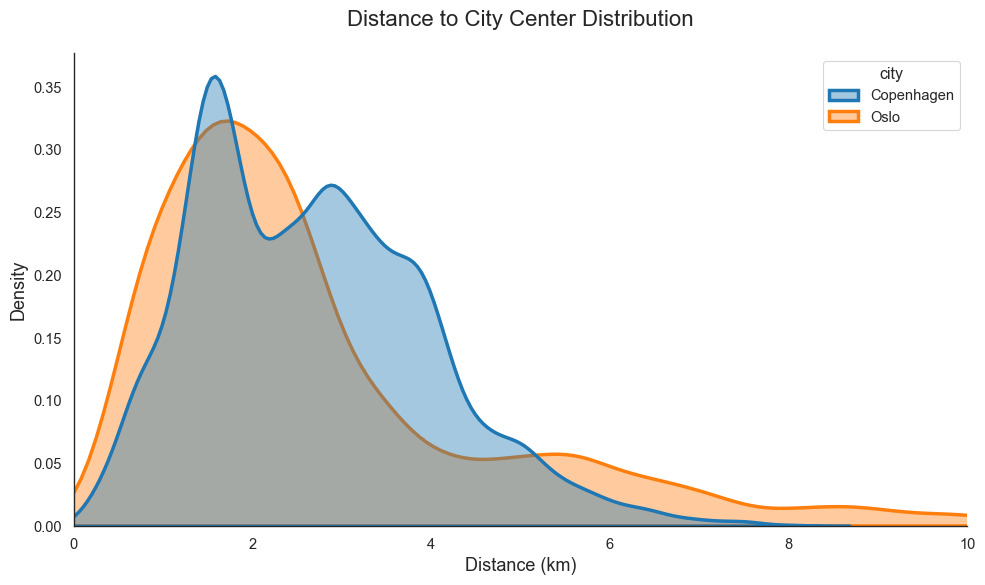

In [8]:
# Plot 3: Distance to center distribution
df_sub = df[df['city'].isin(['Copenhagen', 'Oslo'])].copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_sub, 
    x='distance_to_center_km', 
    hue='city', 
    fill=True, 
    common_norm=False, 
    palette={'Copenhagen': '#1f77b4', 'Oslo': '#ff7f0e'},
    alpha=0.4, 
    linewidth=2.5
)

plt.title('Distance to City Center Distribution', fontsize=16, pad=20)
plt.xlabel('Distance (km)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.xlim(0, 10)
sns.despine()
plt.tight_layout()
plt.savefig('distance_distribution_clean.png', dpi=300, bbox_inches='tight')
plt.show()